Sealevel monitor
========

This document is used to monitor the current sea level along the Dutch coast. The sea level is measured using a number of tide gauges. Six long running tide gauges are considered "main stations". The mean of these stations is used to estimate the "current sea-level rise". The measurements since 1890 are taken into account. Measurements before that are considered less valid because the Amsterdam Ordnance Datum was not yet normalized. 

In [1]:
# this is a list of packages that are used in this notebook
# these come with python
import io
import zipfile
import functools
import bisect
import datetime
import pathlib

import sys
before = {str(m) for m in sys.modules}
# you can install these packages using pip or anaconda
# (requests numpy pandas bokeh pyproj statsmodels)

# for downloading
import requests
import netCDF4

# computation libraries
import numpy as np
import pandas as pd


# coordinate systems
import pyproj 

# statistics
import statsmodels.api as sm
import statsmodels.multivariate.pca
import statsmodels.tsa.seasonal


# plotting
import bokeh.io
import bokeh.plotting
import bokeh.tile_providers
import bokeh.palettes

import seaborn as sns

# this package gives a lot of warnings about incompatibility with 3.1 
# replace 
import windrose
import matplotlib.colors
import matplotlib.cm
import matplotlib.pyplot as plt
matplotlib.projections.register_projection(windrose.WindroseAxes)
import cmocean.cm

# displaying things
from ipywidgets import Image
import IPython.display

# add the top level package
import slr.models
import slr.psmsl
import slr.wind
import slr.plots
import slr.tables


import slr

In [2]:
# Some settings for interactive plots
# If this notebook is not showing up with figures, you can use the following url:
# https://nbviewer.ipython.org/github/openearth/notebooks/blob/master/sealevelmonitor.ipynb
bokeh.io.output_notebook()
# we're using matplotlib for polar plots (non-interactive)
%matplotlib inline

src_dir = slr.get_src_dir()


Loading BokehJS ...

In [3]:
# use local data, make sure you updated the datasets with the makefiles
local = True

# Drop Delfzijl, because it contains uncorrected subsidence
drop_delfzijl = True

# Wind product should always be selected, because it is also used for plots and comparison to surge
wind_product = 'NCEP1'
gtsm_version = '2023'

# If you subtract surge, you should set with_wind to False
# When you set subtract surge to True 
subtract_surge = True
# Explicitly do not select wind, as we already correct for surge
# You can also set this to None to have it autopicked based on AIC
with_wind = False

# Define a reference point for the wind correction. This should be somewhere offshore, away for the coast. 
# This is needed because wind needs some length to generate the wind setup
reference_point_wind = {"lat": 53, "lon": 3}

# By default we analyse the annual data. If you switch to monthly you also should include some seasonal model. 
default_dataset_name = 'rlr_annual'




Sea-level measurements
=============
In this section we download sea-level measurements. The global collection of tide gauge records at the PSMSL is used to access the data. The other way to access the data is to ask the service desk data at Rijkswaterstaat. There are two types of datasets the "Revised Local Reference" and "Metric". For the Netherlands the difference is that the "Revised Local Reference" undoes the corrections from the  NAP correction in 2014, to get a consistent dataset. Here we transform the RLR back to NAP (without undoing the correction).

**Check:** Make sure that you verify the rlr2nap parameters.

The rlrnap computes the rlr back to  latest NAP (ignoring the undoing of the NAP correction) the alpha paramater is the dominant wind direction for the stations, based on de Ronde 2013. Id's are the station ids in the PSMSL dataset. They may change from year to year as the PSMSL 0 point is arbitary. You can lookup the relevant parameters in the schematic diagram like this: https://www.psmsl.org/data/obtaining/rlr.diagrams/20.php

In [4]:
zipfiles = slr.psmsl.get_zipfiles(local=local)
main_stations = slr.psmsl.get_main_stations()
zipfiles


{'met_monthly': <zipfile.ZipFile filename='/Users/baart_f/src/sealevel/data/psmsl/met_monthly.zip' mode='r'>,
 'rlr_monthly': <zipfile.ZipFile filename='/Users/baart_f/src/sealevel/data/psmsl/rlr_monthly.zip' mode='r'>,
 'rlr_annual': <zipfile.ZipFile filename='/Users/baart_f/src/sealevel/data/psmsl/rlr_annual.zip' mode='r'>}

In [5]:
# Check these numbers with the table
main_stations[['name', 'psmsl_id', 'msl-rlr', 'msl-nap', 'nap-rlr']]

,name,psmsl_id,msl-rlr,msl-nap,nap-rlr
id,,,,,
20,Vlissingen,20,6976,46,6930
22,Hoek van Holland,22,6987,114,6873
23,Den Helder,23,6962,16,6946
24,Delfzijl,24,6953,130,6823
25,Harlingen,25,7024,110,6914
32,IJmuiden,32,7014,64,6950


In [6]:
# the main stations are defined by their ids
main_stations_idx = list(main_stations.index)
main_stations_idx

[20, 22, 23, 24, 25, 32]

In [7]:
# download the zipfile

zipfile = zipfiles[default_dataset_name]
stations = slr.psmsl.get_station_list(zipfiles[default_dataset_name], dataset_name=default_dataset_name)
# the dutch stations in the PSMSL database, make a copy
# or use stations.coastline_code == 150 for all dutch stations
selected_stations = pd.merge(main_stations, stations, left_index=True, right_index=True, suffixes=['_rws', '_psmsl'])
# set the main stations, this should be a list of 6 stations
selected_stations['name'] = selected_stations['name_rws']
selected_stations

,name_rws,msl-rlr,msl-nap,nap-rlr,alpha,ddl_id,location,psmsl_id,gtsm_id,gtsm_id_2023,...,lat,lon,name_psmsl,coastline_code,station_code,quality,met_monthly_url,rlr_monthly_url,rlr_annual_url,name
id,,,,,,,,,,,,,,,,,,,,,
20,Vlissingen,6976,46,6930,118,VLISSGN,Vlissingen,20,NWS_NO_TS_MO_Vlissingen,39624,...,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Vlissingen
22,Hoek van Holland,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,NWS_NO_TS_MO_HoekVanHolland,39594,...,51.977500,4.120000,HOEK VAN HOLLAND,150,051,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Hoek van Holland
23,Den Helder,6962,16,6946,107,DENHDR,Den Helder,23,NWS_NO_TS_MO_DenHelder,39574,...,52.964444,4.745000,DEN HELDER,150,031,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Den Helder
24,Delfzijl,6953,130,6823,117,DELFZL,Delfzijl,24,NWS_NO_TS_MO_Delfzijl,39573,...,53.326389,6.933056,DELFZIJL,150,001,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Delfzijl
25,Harlingen,7024,110,6914,108,HARLGN,Harlingen,25,NWS_NO_TS_MO_Harlingen,39585,...,53.175556,5.409444,HARLINGEN,150,021,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Harlingen
32,IJmuiden,7014,64,6950,110,IJMDBTHVN,IJmuiden,32,NWS_NO_TS_MO_Ijmuiden,39600,...,52.462222,4.554722,IJMUIDEN,150,041,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,IJmuiden


In [8]:
# show the plot (background is missing after tile update)
bokeh.io.show(slr.plots.stations_map(stations, selected_stations))

Now that we have defined which tide gauges we are monitoring we can start downloading the relevant data. 

Sea-level explained  
=======
The sea-level is dependent on several factors. We call these factors explanatory, exogenous or independent variables. The main factors that influence the monthly and annual sea level include wind, pressure, river discharge, tide and oscilations in the ocean. Based on previous analysis we include wind and nodal tide as independent variables. To be able to include wind, we use the monthly 10m wind based on the NCEP reanalysis of the NCAR. To be more specific we include the squared u and v wind components. Unfortunately the wind series only go back to 1948. To be able to include them without having to discard the sea level measurements before 1948, we fill in the missing data with the mean. 

We don't include timeseries of climate change related explanatory variables like trends in density and ice loss at Greenland and Antarctica. These are calculated seperately (see analysis notebooks). Here we only include the incidental (storms) and periodic (tide). We also show the irregular periodic North Atlantic Osciliation here, but we don't correct for it, as this metric does not have such a strong correlation with the water level at the Dutch coast, thus including it will also reduce the explainability of the current sea-level rise. 

In [9]:
# Use a point from NCEP 1 as reference point

monthly_wind_products, annual_wind_products = slr.wind.get_wind_products(reference_point_wind=reference_point_wind)

annual_wind_df = annual_wind_products[wind_product]
monthly_wind_df = monthly_wind_products[wind_product]

monthly_gtsm_df, annual_gtsm_df = slr.wind.get_gtsm_dfs(version=gtsm_version)

found point 52.3799 3.75
found point 53.0 3.0


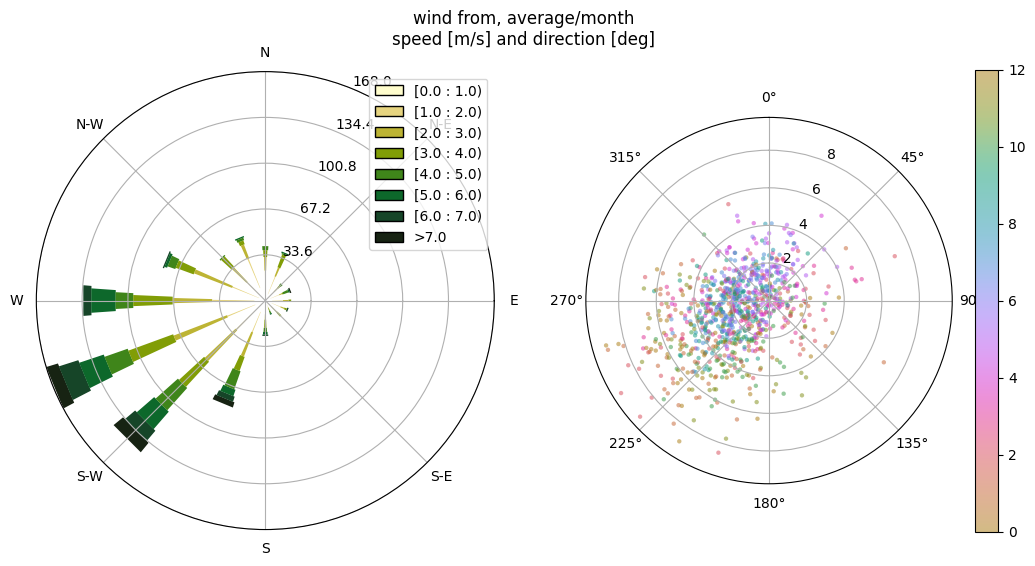

In [10]:
slr.plots.wind_plot(monthly_wind_df)

## Comparison wind vs surge trends
Here we show that the absolute wind trend (in NCEP1) has a different trend from the surge in GTSM. Possible causes for these different trends are spurious trend changes, wind direction changes (if wind is more directed off-land). This needs further investigation. See also [this paper](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018JD030083) for some context.

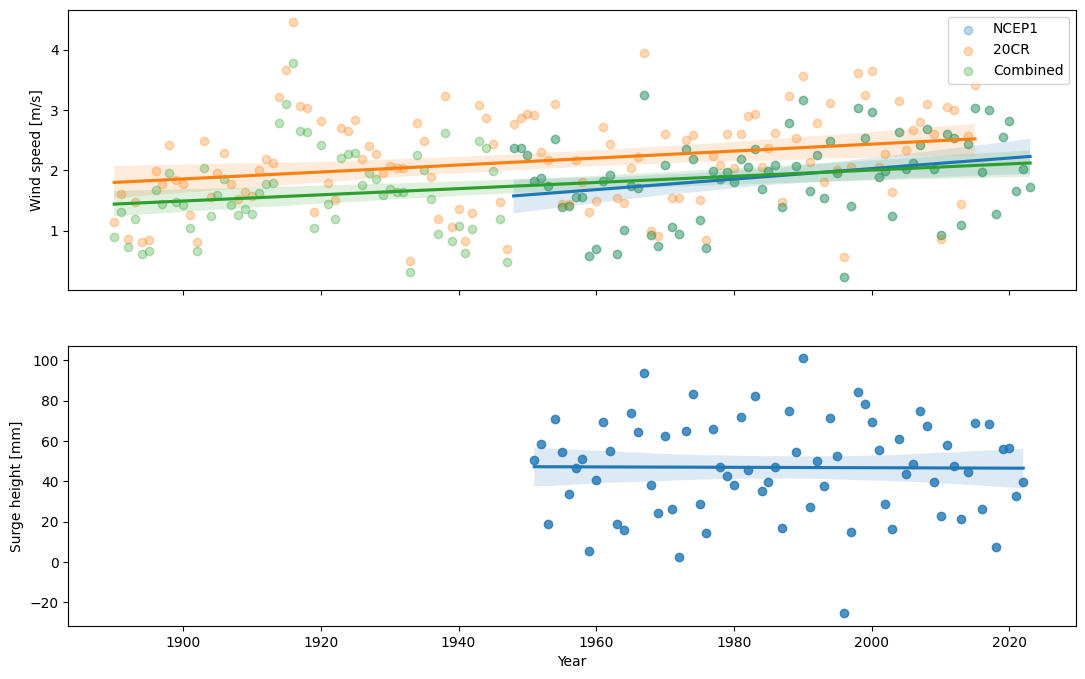

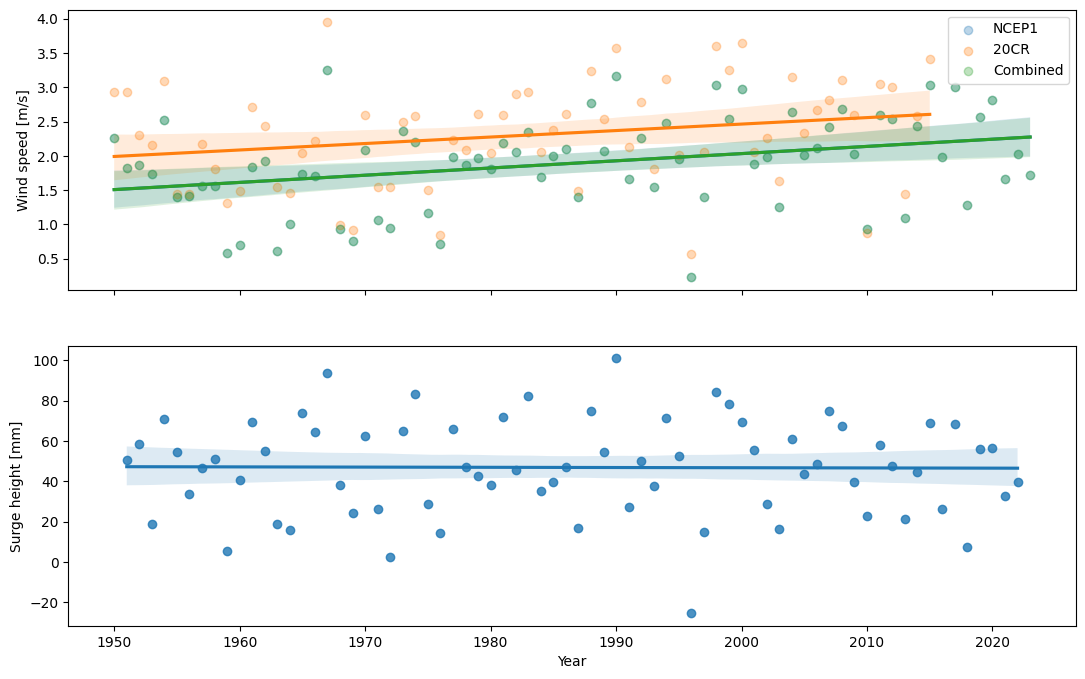

In [12]:
slr.plots.wind_trends(annual_wind_products, annual_gtsm_df, lowess=False, start_year=1890);
slr.plots.wind_trends(annual_wind_products, annual_gtsm_df, lowess=False, start_year=1950);

## Relation between wind direction and surge. 
The red dots in the left plot correspond to the lower surge heights in the right plot. These are the somehwat rare occasions when we have strong winds and negative surge. U, V are "wind to" directions. So if we have a strong wind from the east, this corresponds to a negative surge. 

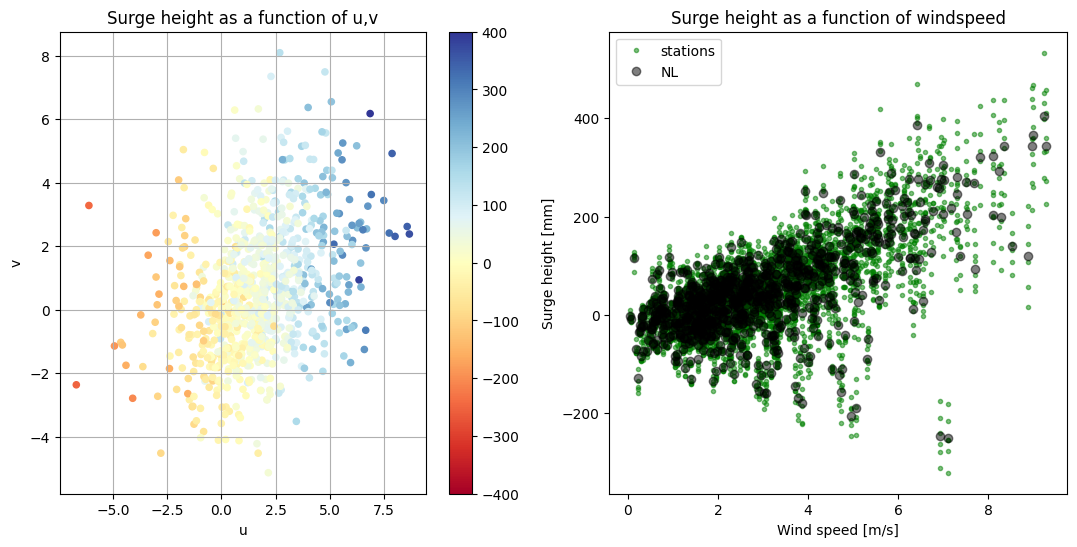

In [13]:
slr.plots.surge_vs_wind(monthly_gtsm_df, monthly_wind_df);

In [14]:
selected_stations

,name_rws,msl-rlr,msl-nap,nap-rlr,alpha,ddl_id,location,psmsl_id,gtsm_id,gtsm_id_2023,...,lat,lon,name_psmsl,coastline_code,station_code,quality,met_monthly_url,rlr_monthly_url,rlr_annual_url,name
id,,,,,,,,,,,,,,,,,,,,,
20,Vlissingen,6976,46,6930,118,VLISSGN,Vlissingen,20,NWS_NO_TS_MO_Vlissingen,39624,...,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Vlissingen
22,Hoek van Holland,6987,114,6873,117,HOEKVHLD,Hoek van Holland,22,NWS_NO_TS_MO_HoekVanHolland,39594,...,51.977500,4.120000,HOEK VAN HOLLAND,150,051,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Hoek van Holland
23,Den Helder,6962,16,6946,107,DENHDR,Den Helder,23,NWS_NO_TS_MO_DenHelder,39574,...,52.964444,4.745000,DEN HELDER,150,031,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Den Helder
24,Delfzijl,6953,130,6823,117,DELFZL,Delfzijl,24,NWS_NO_TS_MO_Delfzijl,39573,...,53.326389,6.933056,DELFZIJL,150,001,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Delfzijl
25,Harlingen,7024,110,6914,108,HARLGN,Harlingen,25,NWS_NO_TS_MO_Harlingen,39585,...,53.175556,5.409444,HARLINGEN,150,021,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,Harlingen
32,IJmuiden,7014,64,6950,110,IJMDBTHVN,IJmuiden,32,NWS_NO_TS_MO_Ijmuiden,39600,...,52.462222,4.554722,IJMUIDEN,150,041,N,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,http://www.psmsl.org/data/obtaining/rlr.diagra...,IJmuiden


In [15]:
selected_stations = slr.psmsl.add_series_to_stations(selected_stations, wind_product=wind_product, gtsm_version=gtsm_version)
# each station should now have surge

found point 52.3799 3.75
found point 53.0 3.0


Now that we have all data downloaded. We added wind and the surge to the annual data for each station, we can compute the mean.

In [16]:
# compute the mean, only for annual
selected_stations = slr.psmsl.add_aggregated_stations(selected_stations)


In [17]:
# pick the station
if drop_delfzijl:
    mean_df = selected_stations.loc[10001, "rlr_annual"]
else:
    mean_df = selected_stations.loc[10000, "rlr_annual"]

# Compute surge anomaly corrected waterlevel
# TODO: this should be done in function that reads the data, also compute height - surge anomaly
# mean_df['height-surge'] = mean_df['height'] - (mean_df['surge_mm'] - mean_df['surge_mm'].mean())
# mean_df.plot('year', ['height', 'height-surge'])
mean_df

,year,height,u2,v2,surge_mm,station,height - surge,height - surge anomaly
t,,,,,,,,
1890-01-01,1890.0,-203.4,6.343871,2.392497,44.512700,10001,-247.912700,-203.400000
1891-01-01,1891.0,-189.4,6.343871,2.392497,44.512700,10001,-233.912700,-189.400000
1892-01-01,1892.0,-174.4,6.343871,2.392497,44.512700,10001,-218.912700,-174.400000
1893-01-01,1893.0,-154.0,6.343871,2.392497,44.512700,10001,-198.512700,-154.000000
1894-01-01,1894.0,-147.0,6.343871,2.392497,44.512700,10001,-191.512700,-147.000000
...,...,...,...,...,...,...,...,...
2018-01-01,2018.0,26.2,4.296787,2.208767,5.465939,10001,20.734061,65.246761
2019-01-01,2019.0,92.0,7.962882,4.212188,53.384473,10001,38.615527,83.128227
2020-01-01,2020.0,96.6,9.839990,6.934233,53.691680,10001,42.908320,87.421020


In [18]:
bokeh.io.show(
    slr.plots.timeseries_plot(
        selected_stations=selected_stations, 
        mean_df=mean_df, 
        dataset_name=default_dataset_name
    )
)


## Surge correction
The following plot shows the surge correction for all stations. You can see that the large within-year variation is corrected for. A month with a large storm can result in 40cm higher monthly average. The remaining cycle is the seasonal water level variation, not due to pressure and average wind. Notice the remaining autocorrelation (a year with high surge is more likely followed by another year with high surge). We think this is partly due to the nodal tide and partly due to decadal cycles. 

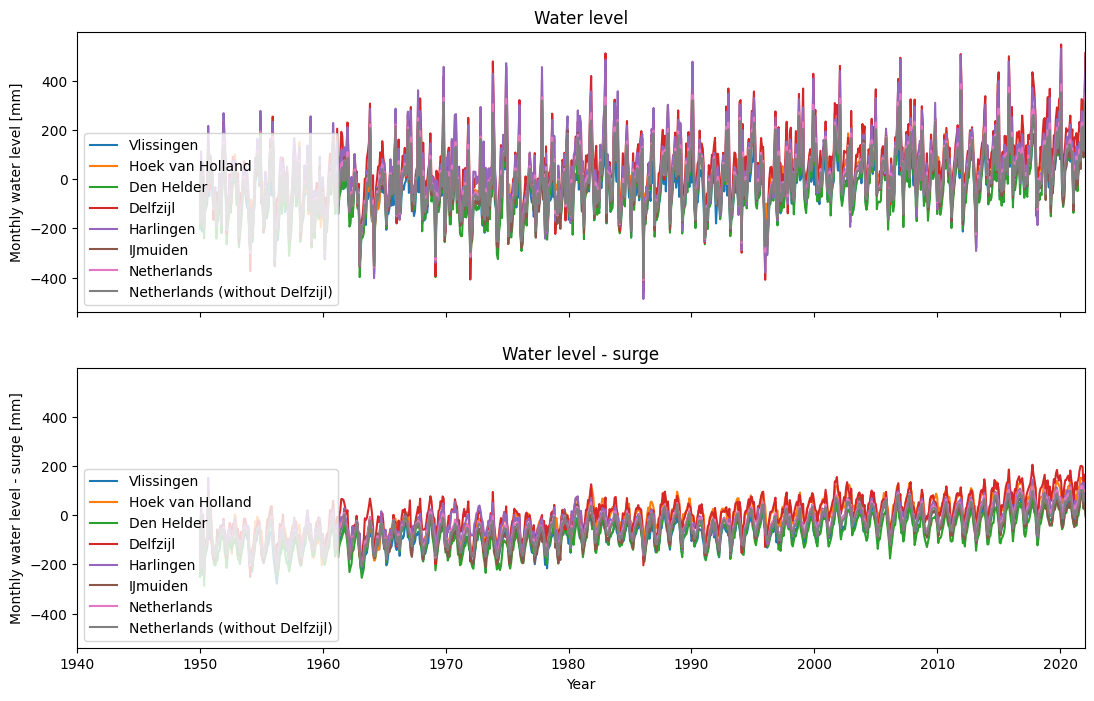

In [19]:
slr.plots.surge_vs_waterlevel(
    selected_stations
)

In [20]:
bokeh.io.show(
    slr.plots.timeseries_plot(
        selected_stations=selected_stations, 
        mean_df=mean_df, 
        dataset_name='rlr_monthly'
    )
)

## Top n tables
We use these to show if we have a new highest sea-level recorded. Notice that the waterlevel - surge are more monotonuous increasing, this is partly due to nodal tide. 

In [21]:
slr.tables.top_n_tables(selected_stations)

Methods
=====
Now we can define the statistical model. The "current sea-level rise" is defined by the following formula. Please note that t is relative to the epoch of 1970. This model is referred to as `linear_model` in the code. 
$H(t) = a + b_{trend}(t) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t)$

The terms are refered to as Constant ($a$), Trend ($b_{trend}$), Nodal U ($b_u$) and Nodal V ($b_v$), Wind ($b_{wind^2}$), the autoregressive term $\varepsilon(t-1)$ and error $\varepsilon$. 


Alternative models are used to detect if sea-level rise is increasing. These models include the broken linear model, defined by a possible change in trend starting at 1993. This timespan is the start of the "satellite era" (start of TOPEX/Poseidon measurements), it is also often referred to as the start of acceleration because the satellite measurements tend to show a higher rate of sea level than the "tide-gauge era" (1900-2000). If this model fits better than the linear model, one could say that there is a "increase in sea-level rise".  This model is refered to as `broken_linear_model`. These models are covered in the section [Sea-level acceleration](#Is-there-a-sea-level-acceleration?).

$H(t) = a + b_{trend}(t) + b_{broken}(t > 1993)*(t-1993) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t)$

Another way to look at increased sea-level rise is to look at sea-level acceleration. To detect sea-level acceleration one can use a quadratic model. This model is referred to as `quadratic_model`. 

$H(t) = a + b_{trend}(t) + b_{quadratic}(t*t) + b_{u}\cos(2\pi\frac{t}{18.613}) + b_{v}\sin(2\pi\frac{t}{18.613}) + b_{wind_{u^2}}wind_{u^2}(t) + b_{wind_{v^2}}wind_{v^2}(t) + \varepsilon(t-1) + \varepsilon(t)$



We can compare the model with and without wind. Wind drives the storm surge at the coast. If there is a strong wind blowing it can raise the waterlevel by meters, 2 meter is not uncommon. If the wind keeps blowing for two days this will raise the annual averaged waterlevel by more than a centimeter, even if it occurs during low tide. 
We can verify that wind is an important factor for the average sea level by comparing the model with and without wind. 
Things to check for include: 
- Durbin Watson should be >1 for no worries, >2 for no autocorrelation
- JB should be non-significant for normal residuals
- abs(x2.t) + abs(x3.t) should be > 3, otherwise adding nodal is not useful
- The model with wind should also be significant better, check F value difference with 2 and N-5 degrees of freedom. 

In [22]:
# first the model 
quantity = 'height'
yname = "Sea surface height"
if subtract_surge:
    quantity = "height - surge anomaly"
    yname = "Sea surface height - surge anomaly"

linear_without_wind_fit, linear_without_wind_names = slr.models.linear_model(
    mean_df, with_wind=False, with_ar=True, quantity=quantity
)
table = linear_without_wind_fit.summary(
    yname=yname, 
    xname=linear_without_wind_names, 
    title='Linear model without (1890-current)'
)
IPython.display.display(table)

# and then the model with wind
# explictly use height here, otherwise we might use height - surge
linear_with_wind_fit, linear_with_wind_names = slr.models.linear_model(
    mean_df, 
    with_wind=True, 
    with_ar=True,
    quantity='height'
)
table = linear_with_wind_fit.summary(
    yname="Sea surface height", 
    xname=linear_with_wind_names,
    title='Linear model with wind (1948-current)'
)
IPython.display.display(table)

# Wikipedia, based on Akaike(1974): Given a set of candidate models 
# for the data, the preferred model is the one with the minimum AIC value. 
# If with_wind is None, pick it based on AIC
if with_wind is None:
    if (linear_without_wind_fit.aic < linear_with_wind_fit.aic):
        print('The linear model without wind is a higher quality model (smaller AIC) than the linear model with wind.')
        with_wind = False
    else:
        print('The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.')
        with_wind = True

if subtract_surge:
    assert with_wind == False, "If you subtract surge, you should set with_wind to False"
    print("We are not modelling wind because we are already modelling surge. Otherwise we would correct for wind twice over the period where we have surge.")

if with_wind:
    linear_fit = linear_with_wind_fit
    linear_names = linear_with_wind_names
else: 
    linear_fit = linear_without_wind_fit
    linear_names = linear_without_wind_names


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Linear model without (1890-current)                              
==============================================================================================
Dep. Variable:     Sea surface height - surge anomaly   R-squared:                       0.877
Model:                                          GLSAR   Adj. R-squared:                  0.874
Method:                                 Least Squares   F-statistic:                     308.7
Date:                                Mon, 20 Nov 2023   Prob (F-statistic):           2.13e-58
Time:                                        10:14:16   Log-Likelihood:                -581.61
No. Observations:                                 132   AIC:                             1171.
Df Residuals:                                     128   BIC:                             1183.
Df Model:                                           3                                         
Covariance Type:                                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -33.8248      2.109    -16.035      0.000     -37.959     -29.690
Trend          1.9186      0.063     30.307      0.000       1.794       2.043
Nodal U        3.9740      3.305      1.202      0.229      -2.503      10.451
Nodal V      -11.9621      3.295     -3.631      0.000     -18.420      -5.504
==============================================================================
Omnibus:                        4.727   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                6.327
Skew:                          -0.077   Prob(JB):                       0.0423
Kurtosis:                       4.062   Cond. No.                         56.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Linear model with wind (1948-current)                     
==============================================================================
Dep. Variable:     Sea surface height   R-squared:                       0.877
Model:                          GLSAR   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     259.1
Date:                Mon, 20 Nov 2023   Prob (F-statistic):           1.69e-64
Time:                        10:14:16   Log-Likelihood:                -592.23
No. Observations:                 132   AIC:                             1196.
Df Residuals:                     126   BIC:                             1214.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -79.6008      5.657    -14.072      0.000     -90.688     -68.514
Trend          1.8651      0.066     28.392      0.000       1.736       1.994
Nodal U        3.5901      3.497      1.027      0.305      -3.264      10.444
Nodal V      -12.6228      3.425     -3.685      0.000     -19.336      -5.909
Wind $u^2$     7.2618      0.680     10.687      0.000       5.930       8.594
Wind $v^2$    -0.4539      1.033     -0.439      0.660      -2.479       1.571
==============================================================================
Omnibus:                        1.174   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.556   Jarque-Bera (JB):                0.743
Skew:                          -0.047   Prob(JB):                        0.690
Kurtosis:                       3.355   Cond. No.                         93.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

We are not modelling wind because we are already modelling surge. Otherwise we would correct for wind twice over the period where we have surge.


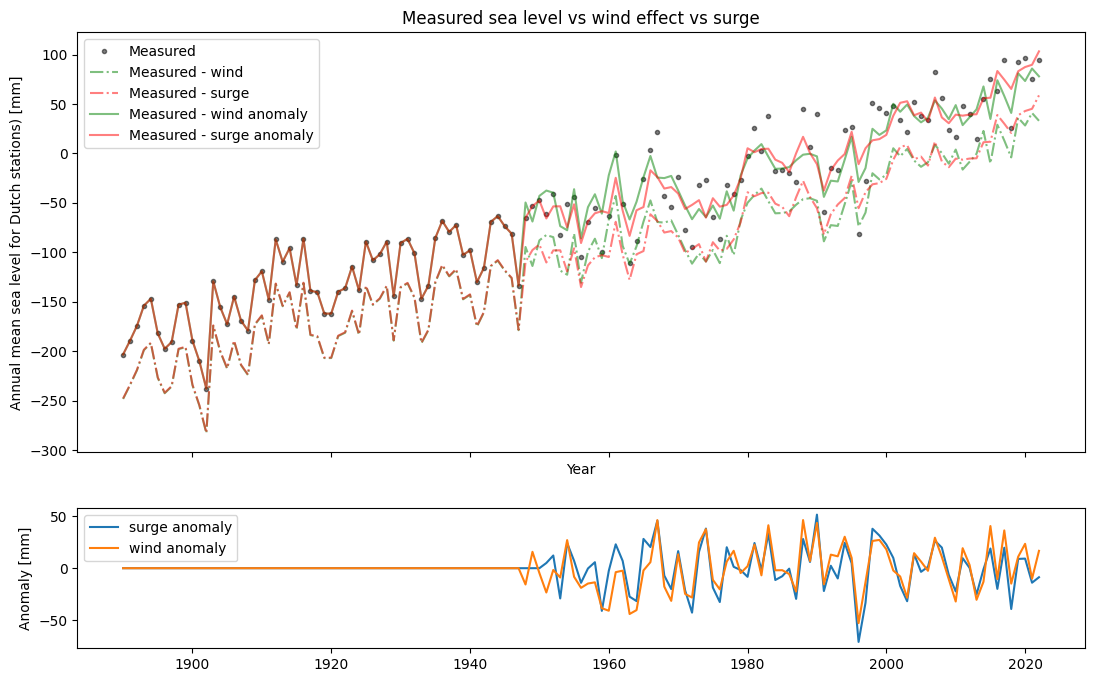

In [23]:
slr.plots.wind_anomaly_vs_surge_anomaly(
    mean_df, 
    fit=linear_with_wind_fit, 
    names=linear_with_wind_names
);


In [24]:
if subtract_surge:
    print("This figure is not used when surge is subtracted.")
fig = slr.plots.wind_vs_no_wind(
    mean_df=mean_df, 
    quantity=quantity, 
    yname=yname,
    linear_with_wind_fit=linear_with_wind_fit, 
    linear_without_wind_fit=linear_without_wind_fit
)
bokeh.io.show(fig)

This figure is not used when surge is subtracted.


In [25]:
linear_fit.summary(xname=linear_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             GLSAR Regression Results                             
==================================================================================
Dep. Variable:     height - surge anomaly   R-squared:                       0.877
Model:                              GLSAR   Adj. R-squared:                  0.874
Method:                     Least Squares   F-statistic:                     308.7
Date:                    Mon, 20 Nov 2023   Prob (F-statistic):           2.13e-58
Time:                            10:14:17   Log-Likelihood:                -581.61
No. Observations:                     132   AIC:                             1171.
Df Residuals:                         128   BIC:                             1183.
Df Model:                               3                                         
Covariance Type:                      HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -33.8248      2.109    -16.035      0.000     -37.959     -29.690
Trend          1.9186      0.063     30.307      0.000       1.794       2.043
Nodal U        3.9740      3.305      1.202      0.229      -2.503      10.451
Nodal V      -11.9621      3.295     -3.631      0.000     -18.420      -5.504
==============================================================================
Omnibus:                        4.727   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                6.327
Skew:                          -0.077   Prob(JB):                       0.0423
Kurtosis:                       4.062   Cond. No.                         56.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

Regional variability
=====================
It is known that the sea-level rise is not constant along the coast. The figures below show that the sea-level is rising faster at some stations. Some of these variations go back to the 1900's. There are several coastal interventions with known effect to the stations. The construction of the [Afsluitdijk](https://en.wikipedia.org/wiki/Afsluitdijk) (1927-1932), the [Oosterscheldekering](https://en.wikipedia.org/wiki/Oosterscheldekering) (1969-1987), the [Maeslantkering](https://en.wikipedia.org/wiki/Maeslantkering) (1991-1997) all have influence on the mean sea level, mainly due to changes in tidal amplitudes. 

Using the mean of the six tidal guages is the current approach. There are alternatives, for example one can use the principal component of the differences (between months/years). It is then assumed that only the common variance shared accross all stations is representative of the shared sea level. Most of the variance is shared between all stations and this results in a similar trend as using the mean. This method is referred to as EOF, PCA or SSA. See the analysis folder for an example.

In [26]:
station_fits = {}
for name, station in selected_stations.iterrows():
    df = station[default_dataset_name]
    df = df[df.year >= 1890]
    fit, names = slr.models.linear_model(df, with_wind=with_wind, quantity=quantity)
    smry = fit.summary(xname=names, title=station['name'])
    # somehow a formatted name is not showing up
    print(station['name'], quantity)
    station_fits[name] = fit

    IPython.display.display(smry.tables[1])

Vlissingen height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-76.3217,2.801,-27.251,0.000,-81.811,-70.832
Trend,2.1907,0.098,22.279,0.000,1.998,2.383
Nodal U,4.3410,4.661,0.931,0.352,-4.794,13.476
Nodal V,-13.4992,4.295,-3.143,0.002,-21.918,-5.081


Hoek van Holland height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-6.9716,2.814,-2.477,0.013,-12.487,-1.456
Trend,2.3837,0.077,30.956,0.000,2.233,2.535
Nodal U,-0.0497,4.510,-0.011,0.991,-8.888,8.789
Nodal V,-9.6421,4.098,-2.353,0.019,-17.673,-1.611


Den Helder height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-57.4849,2.734,-21.025,0.000,-62.844,-52.126
Trend,1.5468,0.075,20.499,0.000,1.399,1.695
Nodal U,4.6148,3.854,1.198,0.231,-2.938,12.168
Nodal V,-13.6434,4.530,-3.012,0.003,-22.522,-4.764


Delfzijl height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,30.7851,3.339,9.219,0.000,24.240,37.330
Trend,2.0139,0.101,19.880,0.000,1.815,2.212
Nodal U,2.3608,5.510,0.428,0.668,-8.439,13.160
Nodal V,-13.8954,4.675,-2.972,0.003,-23.058,-4.733


Harlingen height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,16.4444,3.331,4.937,0.000,9.916,22.973
Trend,1.3787,0.095,14.583,0.000,1.193,1.564
Nodal U,1.4870,5.015,0.297,0.767,-8.341,11.315
Nodal V,-10.8310,4.678,-2.315,0.021,-19.999,-1.663


IJmuiden height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-44.3833,3.364,-13.192,0.000,-50.977,-37.789
Trend,2.0900,0.112,18.659,0.000,1.870,2.310
Nodal U,9.9177,5.377,1.845,0.065,-0.621,20.456
Nodal V,-12.8307,5.175,-2.479,0.013,-22.974,-2.688


Netherlands height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-23.0656,2.180,-10.582,0.000,-27.338,-18.793
Trend,1.9345,0.065,29.645,0.000,1.807,2.062
Nodal U,3.6963,3.436,1.076,0.282,-3.038,10.431
Nodal V,-12.2686,3.344,-3.668,0.000,-18.824,-5.714


Netherlands (without Delfzijl) height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-33.8248,2.109,-16.035,0.000,-37.959,-29.690
Trend,1.9186,0.063,30.307,0.000,1.794,2.043
Nodal U,3.9740,3.305,1.202,0.229,-2.503,10.451
Nodal V,-11.9621,3.295,-3.631,0.000,-18.420,-5.504


In [27]:
station_fits = {}
for name, station in selected_stations.iterrows():
    df = station[default_dataset_name]
    df = df[df.year >= 1890]
    fit, names = slr.models.broken_linear_model(df, with_wind=with_wind, quantity=quantity)
    smry = fit.summary(xname=names, title=station['name'])
    # somehow a formatted name is not showing up
    print(station['name'], quantity)
    station_fits[name] = fit

    IPython.display.display(smry.tables[1])

Vlissingen height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-80.6448,3.366,-23.960,0.000,-87.242,-74.048
Trend,2.0797,0.135,15.463,0.000,1.816,2.343
+trend (1993),0.8389,0.407,2.060,0.039,0.041,1.637
Nodal U,4.5982,4.459,1.031,0.302,-4.141,13.338
Nodal V,-12.9126,4.282,-3.016,0.003,-21.305,-4.520


Hoek van Holland height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-11.7216,3.667,-3.196,0.001,-18.910,-4.534
Trend,2.2627,0.106,21.373,0.000,2.055,2.470
+trend (1993),0.9274,0.380,2.443,0.015,0.183,1.672
Nodal U,0.2667,4.370,0.061,0.951,-8.298,8.832
Nodal V,-8.9856,3.999,-2.247,0.025,-16.824,-1.148


Den Helder height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-64.5261,3.193,-20.210,0.000,-70.784,-58.268
Trend,1.3680,0.093,14.730,0.000,1.186,1.550
+trend (1993),1.3797,0.326,4.230,0.000,0.740,2.019
Nodal U,5.1168,3.487,1.468,0.142,-1.717,11.951
Nodal V,-12.6641,4.203,-3.013,0.003,-20.902,-4.426


Delfzijl height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,21.2858,3.590,5.929,0.000,14.249,28.322
Trend,1.7741,0.115,15.361,0.000,1.548,2.000
+trend (1993),1.8718,0.428,4.377,0.000,1.034,2.710
Nodal U,3.1017,4.877,0.636,0.525,-6.456,12.660
Nodal V,-12.5696,4.093,-3.071,0.002,-20.592,-4.547


Harlingen height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,5.4458,3.451,1.578,0.115,-1.319,12.211
Trend,1.1012,0.103,10.670,0.000,0.899,1.303
+trend (1993),2.1385,0.372,5.742,0.000,1.408,2.869
Nodal U,2.1735,4.185,0.519,0.603,-6.028,10.375
Nodal V,-9.2059,3.886,-2.369,0.018,-16.823,-1.589


IJmuiden height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-45.7221,4.374,-10.452,0.000,-54.296,-37.149
Trend,2.0556,0.158,13.040,0.000,1.747,2.365
+trend (1993),0.2598,0.518,0.501,0.616,-0.756,1.276
Nodal U,9.9973,5.386,1.856,0.063,-0.559,20.553
Nodal V,-12.6507,5.212,-2.427,0.015,-22.865,-2.436


Netherlands height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-29.2864,2.414,-12.130,0.000,-34.019,-24.554
Trend,1.7775,0.079,22.477,0.000,1.622,1.932
+trend (1993),1.2246,0.269,4.559,0.000,0.698,1.751
Nodal U,4.1771,3.077,1.358,0.175,-1.853,10.207
Nodal V,-11.3948,3.036,-3.753,0.000,-17.346,-5.444


Netherlands (without Delfzijl) height - surge anomaly


,coef,std err,z,P>|z|,[0.025,0.975]
Constant,-39.4059,2.400,-16.422,0.000,-44.109,-34.703
Trend,1.7774,0.079,22.454,0.000,1.622,1.933
+trend (1993),1.0973,0.268,4.094,0.000,0.572,1.623
Nodal U,4.3963,3.014,1.459,0.145,-1.510,10.303
Nodal V,-11.1808,3.056,-3.659,0.000,-17.170,-5.192


In [28]:
p = slr.plots.station_comparison_linear_vs_broken_linear(
    selected_stations=selected_stations, 
    quantity=quantity, 
    yname=yname, 
    with_wind=with_wind,
    dataset_name=default_dataset_name
)
p.height = 800
p.legend.location = "top_left"
bokeh.io.show(p)


Another thing we can look at is the regional variability of unexplained variance. The largest peaks are found in Delfzijl at the start of the measurements. The measured waterlevel was lower in that year. Delfzijl is more affected by storm surges than most other stations due to it's position in the Eems. Another outlier is the measurement in the 30's in Den Helder, this is likely due to the construction of the Afsluitdijk. The other residuals mostly occur on all stations at the same time. This indicates that it is more likely that our estimate of the wind is not optimal yet. We do see a periodicity in the residuals of about 6 years. This does not match with any of the known climate indices. 
Variance descreasess after 1948 because the reanalysis of wind is included after that. 

Is there a sea-level acceleration?
==================

The following section computes two common models to detect sea-level acceleration.  The broken linear model expects that sea level has been rising faster since 1990. The quadratic model assumes that the sea-level is accelerating continuously. Both models are compared to the linear model. The extra terms are tested for significance and the AIC is computed to see which model is "better". 

In [29]:
# use wind if it was a better model
broken_linear_fit, broken_linear_names = slr.models.broken_linear_model(
    mean_df, 
    with_wind=with_wind, 
    quantity=quantity
)

In [30]:
quadratic_fit, quadratic_names = slr.models.quadratic_model(mean_df, with_wind=with_wind, quantity=quantity)
broken_quadratic_fit, broken_quadratic_names = slr.models.broken_quadratic_model(
    mean_df, 
    with_wind=with_wind,
    quantity=quantity,
    start_acceleration=1960
    
)

In [31]:
# summary of the broken linear model
print('autoregressive parameter rho = %s' % broken_linear_fit.history['rho'][-1])
IPython.display.display(broken_linear_fit.summary(yname=yname, xname=broken_linear_names))


autoregressive parameter rho = [0.22407388]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   GLSAR Regression Results                                   
==============================================================================================
Dep. Variable:     Sea surface height - surge anomaly   R-squared:                       0.898
Model:                                          GLSAR   Adj. R-squared:                  0.895
Method:                                 Least Squares   F-statistic:                     450.5
Date:                                Mon, 20 Nov 2023   Prob (F-statistic):           5.70e-74
Time:                                        10:14:17   Log-Likelihood:                -578.02
No. Observations:                                 132   AIC:                             1166.
Df Residuals:                                     127   BIC:                             1180.
Df Model:                                           4                                         
Covariance Type:                                  HC0                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Constant        -39.4059      2.400    -16.422      0.000     -44.109     -34.703
Trend             1.7774      0.079     22.454      0.000       1.622       1.933
+trend (1993)     1.0973      0.268      4.094      0.000       0.572       1.623
Nodal U           4.3963      3.014      1.459      0.145      -1.510      10.303
Nodal V         -11.1808      3.056     -3.659      0.000     -17.170      -5.192
==============================================================================
Omnibus:                        5.761   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.056   Jarque-Bera (JB):                7.676
Skew:                          -0.192   Prob(JB):                       0.0215
Kurtosis:                       4.118   Cond. No.                         57.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [32]:
# summary of the quadratic model
print('autoregressive parameter rho = %s' % quadratic_fit.history['rho'][-1])

quadratic_fit.summary(yname=yname, xname=quadratic_names)

autoregressive parameter rho = [0.26329665]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   GLSAR Regression Results                                   
==============================================================================================
Dep. Variable:     Sea surface height - surge anomaly   R-squared:                       0.885
Model:                                          GLSAR   Adj. R-squared:                  0.881
Method:                                 Least Squares   F-statistic:                     303.5
Date:                                Mon, 20 Nov 2023   Prob (F-statistic):           5.81e-64
Time:                                        10:14:17   Log-Likelihood:                -580.22
No. Observations:                                 132   AIC:                             1170.
Df Residuals:                                     127   BIC:                             1185.
Df Model:                                           4                                         
Covariance Type:                                  HC0                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Constant (in year 1970)   -37.7073      3.171    -11.890      0.000     -43.923     -31.491
Trend                       1.9982      0.061     32.553      0.000       1.878       2.119
Acceleration                0.0030      0.002      1.768      0.077      -0.000       0.006
Nodal U                     3.8782      3.216      1.206      0.228      -2.425      10.181
Nodal V                   -11.6412      3.248     -3.584      0.000     -18.008      -5.275
==============================================================================
Omnibus:                        4.150   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.126   Jarque-Bera (JB):                5.045
Skew:                          -0.095   Prob(JB):                       0.0803
Kurtosis:                       3.939   Cond. No.                     3.36e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 3.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# summary of the broken quadratic model
print('autoregressive parameter rho = %s' % broken_quadratic_fit.history['rho'][-1])
IPython.display.display(broken_quadratic_fit.summary(yname=yname, xname=broken_quadratic_names))


autoregressive parameter rho = [0.23487339]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   GLSAR Regression Results                                   
==============================================================================================
Dep. Variable:     Sea surface height - surge anomaly   R-squared:                       0.895
Model:                                          GLSAR   Adj. R-squared:                  0.891
Method:                                 Least Squares   F-statistic:                     411.1
Date:                                Mon, 20 Nov 2023   Prob (F-statistic):           1.26e-71
Time:                                        10:14:17   Log-Likelihood:                -578.59
No. Observations:                                 132   AIC:                             1167.
Df Residuals:                                     127   BIC:                             1182.
Df Model:                                           4                                         
Covariance Type:                                  HC0                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Constant (in year 1960)   -59.1767      2.798    -21.153      0.000     -64.660     -53.694
Trend                       1.7277      0.100     17.300      0.000       1.532       1.923
Acceleration from 1960      0.0088      0.003      3.245      0.001       0.004       0.014
Nodal U                     4.2029      3.067      1.370      0.171      -1.809      10.215
Nodal V                   -11.4084      3.100     -3.680      0.000     -17.484      -5.333
==============================================================================
Omnibus:                        5.168   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                6.579
Skew:                          -0.172   Prob(JB):                       0.0373
Kurtosis:                       4.038   Cond. No.                     1.81e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 1.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
fits = [
    {
        "name": "linear",
        "fit": linear_fit,
        "names": linear_names
    },
    {
        "name": "linear_with_wind",
        "fit": linear_with_wind_fit,
        "names": linear_with_wind_names
    },
    {
        "name": "linear_without_wind",
        "fit": linear_without_wind_fit,
        "names": linear_without_wind_names
    },
    {
        "name": "broken_linear", 
        "fit": broken_linear_fit,
        "names": broken_linear_names
    },
    {
        "name": "quadratic",
        "fit": quadratic_fit,
        "names": quadratic_names
    },
    {
        "name": "broken_quadratic",
        "fit": broken_quadratic_fit,
        "names": broken_quadratic_names
    }
]

# convert and add information
fits_df = slr.tables.fits_to_fits_df(fits)


# Best acceleration model on top
fits_df = fits_df.sort_values('aic')
# Manual select best model
selected_fit = fits_df.query('name =="broken_linear"').iloc[0]
# export without fit, as that does not fit in csv files
drop_columns = ['fit', 'exog', 'prediction', 'prediction_mean_tide', 'prediction_mean_wind', 'prediction_mean_tide_mean_wind']
export_fits_df = fits_df.drop(columns=drop_columns)
export_fits_df.to_csv('../data/deltares/results/fits.csv')

In [35]:
fits_df

,name,fit,names,aic,F,df_model,prediction,has_tide,has_wind,prediction_mean_tide,prediction_mean_wind,prediction_mean_tide_mean_wind,exog
3,broken_linear,<statsmodels.regression.linear_model.Regressio...,"[Constant, Trend, +trend (1993), Nodal U, Noda...",1166.036719,450.462457,4.0,<statsmodels.regression._prediction.Prediction...,True,False,<statsmodels.regression._prediction.Prediction...,NaN,NaN,Constant Trend +trend (1993) Nodal U ...
5,broken_quadratic,<statsmodels.regression.linear_model.Regressio...,"[Constant (in year 1960), Trend, Acceleration ...",1167.175659,411.098636,4.0,<statsmodels.regression._prediction.Prediction...,True,False,<statsmodels.regression._prediction.Prediction...,NaN,NaN,Constant (in year 1960) Trend Accelerat...
4,quadratic,<statsmodels.regression.linear_model.Regressio...,"[Constant (in year 1970), Trend, Acceleration,...",1170.432807,303.528868,4.0,<statsmodels.regression._prediction.Prediction...,True,False,<statsmodels.regression._prediction.Prediction...,NaN,NaN,Constant (in year 1970) Trend Accelerat...
0,linear,<statsmodels.regression.linear_model.Regressio...,"[Constant, Trend, Nodal U, Nodal V]",1171.224108,308.696786,3.0,<statsmodels.regression._prediction.Prediction...,True,False,<statsmodels.regression._prediction.Prediction...,NaN,NaN,Constant Trend Nodal U Nodal V 0 ...
2,linear_without_wind,<statsmodels.regression.linear_model.Regressio...,"[Constant, Trend, Nodal U, Nodal V]",1171.224108,308.696786,3.0,<statsmodels.regression._prediction.Prediction...,True,False,<statsmodels.regression._prediction.Prediction...,NaN,NaN,Constant Trend Nodal U Nodal V 0 ...
1,linear_with_wind,<statsmodels.regression.linear_model.Regressio...,"[Constant, Trend, Nodal U, Nodal V, Wind $u^2$...",1196.460856,259.111815,5.0,<statsmodels.regression._prediction.Prediction...,True,True,<statsmodels.regression._prediction.Prediction...,<statsmodels.regression._prediction.Prediction...,<statsmodels.regression._prediction.Prediction...,Constant Trend Nodal U Nodal V Wind...


# Constant wind trend
Here we compute the linear model with constant wind and tide

In [36]:
mean_df

,year,height,u2,v2,surge_mm,station,height - surge,height - surge anomaly
t,,,,,,,,
1890-01-01,1890.0,-203.4,6.343871,2.392497,44.512700,10001,-247.912700,-203.400000
1891-01-01,1891.0,-189.4,6.343871,2.392497,44.512700,10001,-233.912700,-189.400000
1892-01-01,1892.0,-174.4,6.343871,2.392497,44.512700,10001,-218.912700,-174.400000
1893-01-01,1893.0,-154.0,6.343871,2.392497,44.512700,10001,-198.512700,-154.000000
1894-01-01,1894.0,-147.0,6.343871,2.392497,44.512700,10001,-191.512700,-147.000000
...,...,...,...,...,...,...,...,...
2018-01-01,2018.0,26.2,4.296787,2.208767,5.465939,10001,20.734061,65.246761
2019-01-01,2019.0,92.0,7.962882,4.212188,53.384473,10001,38.615527,83.128227
2020-01-01,2020.0,96.6,9.839990,6.934233,53.691680,10001,42.908320,87.421020


In [37]:
# before reanalysis started wind  is filled  in with mean,  let's use it from there
mean_wind = mean_df.set_index('year').loc[1890][['u2', 'v2']]
const = linear_with_wind_fit.params['const'] 
trend = linear_with_wind_fit.params['x1'] 
u2 = linear_with_wind_fit.params['x4'] 
v2 = linear_with_wind_fit.params['x5'] 

# linear_with_wind_fit.predict(mean_df)
linear_with_wind_fit.model.exog.shape, linear_with_wind_fit.model.exog_names
exog_df = pd.DataFrame(
    linear_with_wind_fit.model.exog, 
    columns=linear_with_wind_fit.model.exog_names
).copy()
msg = 'Check variable numbers in code below, they changed'
assert linear_with_wind_names == ['Constant', 'Trend', 'Nodal U', 'Nodal V', 'Wind $u^2$', 'Wind $v^2$'], msg
# take 0 nodal tide
exog_df['x2'] = 0 # 
exog_df['x3'] = 0 # 
# take the average wind
exog_df['x4'] = mean_wind['u2']
exog_df['x5'] = mean_wind['v2']
linear_with_mean_wind = linear_with_wind_fit.predict(exog_df)
linear_with_mean_wind_prediction = linear_with_wind_fit.get_prediction(exog=exog_df)
linear_with_mean_wind_confidence_interval = linear_with_mean_wind_prediction.conf_int(obs=False)
linear_with_mean_wind_prediction_interval = linear_with_mean_wind_prediction.conf_int(obs=True)
linear_with_wind_confidence_interval = linear_with_wind_fit.get_prediction().conf_int(obs=False)
linear_with_wind_prediction_interval = linear_with_wind_fit.get_prediction().conf_int(obs=True)



# Sea level due to tide
The sea level is also varying due to the nodal tide (18.613 year period). Because the nodal tide does not only influence the mean sea level but also the tidal amplitude, the measured amplitude can be different from the theoretical value. In order to get an estimate of the measured nodal tide, for long running tide gauges, you can estimate it using two parameters, the nodal u, v. These u and v are just sin and cosin with a period of 18.613 year and amplitude of 1. If you fit a linear model with these included the fit can determine an optimal amplitude and phase for the nodal tide fit for that station. 

The figure below shows the input nodal u,v and the fitted cycle based on the linear fit with wind. 

year                       2022.000000
height                       94.600000
u2                            8.757187
v2                            4.427365
surge_mm                     35.855897
station                   10001.000000
height - surge               58.744103
height - surge anomaly      103.256803
Name: 2022-01-01 00:00:00, dtype: float64

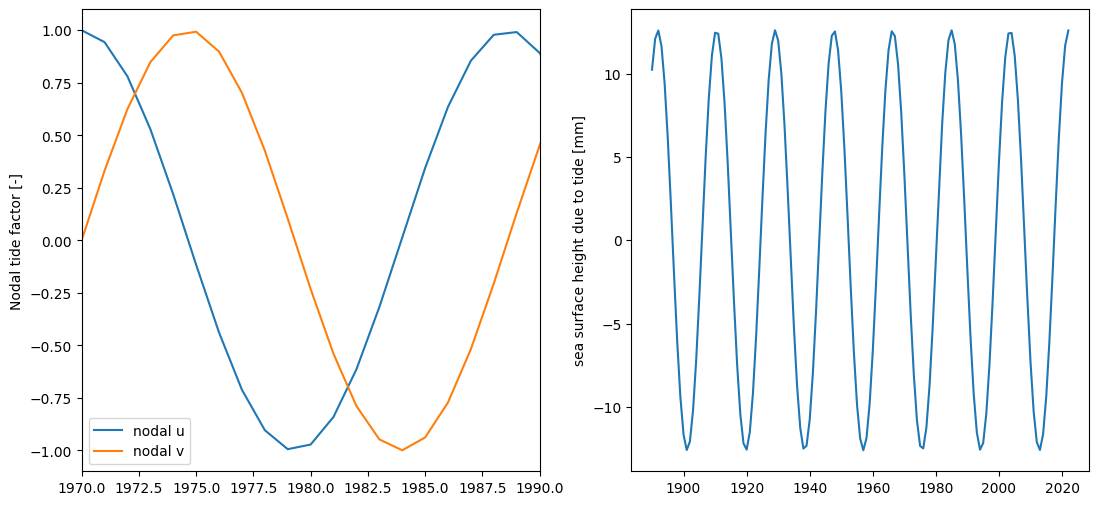

In [38]:
slr.plots.sea_level_due_to_tide(
    mean_df, 
    fit=linear_fit, 
    names=linear_names
);

mean_df.iloc[-1]

# All models combined
The figure below shows an overview of all the calculated variables and models.

In [39]:
bokeh.io.show(slr.plots.model_compare_plot(mean_df, fits_df, quantity=quantity))

# Subtract figure

In [40]:
def subtract_figure(mean_df, linear_with_wind_fit, linear_with_wind_names):
    """
    Show an interactive figure where you can subtract the different components. 
    Tide and wind anomalies are based on the linear model with wind. 
    """
    # linear model
    sea_surface_height_due_to_tide_linear = slr.models.tide_effect(linear_with_wind_fit, linear_with_wind_names)
    wind_effect, wind_anomaly = slr.wind.compute_wind_effect_and_anomaly(linear_with_wind_fit, linear_with_wind_names)
    wind_anomaly[mean_df['year'] < 1979]

    surge_anomaly = mean_df['surge_mm'] - mean_df['surge_mm'].mean()
    surge_or_wind = np.where(mean_df['year'] < 1979, wind_anomaly, surge_anomaly)

    fig = bokeh.plotting.figure(x_range=(1860, 2020), width=900, height=400)

    fig.circle(mean_df['year'], mean_df['height'], legend_label='sea surface height', color='black')
    fig.line(mean_df['year'], mean_df['height'] - sea_surface_height_due_to_tide_linear, legend_label='sea surface height - tide', color='purple')
    fig.line(mean_df['year'], mean_df['height - surge anomaly'], legend_label='sea surface height - surge anomaly', color='blue')
    fig.line(mean_df['year'], mean_df['height'] - wind_anomaly , legend_label='sea surface height - wind anomaly', color='orange')
    fig.line(mean_df['year'], mean_df['height - surge anomaly'] - sea_surface_height_due_to_tide_linear, legend_label='sea surface height - surge anomaly - tide', color='red')
    fig.line(mean_df['year'], mean_df['height'] - wind_anomaly - sea_surface_height_due_to_tide_linear, legend_label='sea surface height - wind anomaly - tide', color='green')

    fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
    fig.xaxis.axis_label = 'year'

    fig.legend.click_policy = "hide"
    fig.legend.location = "top_left"
    return fig

bokeh.io.show(subtract_figure(mean_df, linear_with_wind_fit, linear_with_wind_names))



# Export
Here we export the data in csv format. This information is often requested by others.


In [41]:
sea_surface_height_due_to_tide_linear = slr.models.tide_effect(linear_fit, linear_names)
sea_surface_height_due_to_tide_broken_linear = slr.models.tide_effect(broken_linear_fit, broken_linear_names)

export_df = mean_df.copy().reset_index()
export_df['predicted_linear_with_wind'] = linear_with_wind_fit.predict()
export_df['predicted_linear_without_wind'] = linear_without_wind_fit.predict()
export_df['predicted_linear_mean_wind'] = linear_with_mean_wind
export_df['predicted_linear_mean_wind_ci_025'] = linear_with_mean_wind_confidence_interval[:, 0]
export_df['predicted_linear_mean_wind_ci_975'] = linear_with_mean_wind_confidence_interval[:, 1]
export_df['predicted_linear_mean_wind_pi_025'] = linear_with_mean_wind_prediction_interval[:, 0]
export_df['predicted_linear_mean_wind_pi_975'] = linear_with_mean_wind_prediction_interval[:, 1]
export_df['sea_surface_height_due_to_tide_linear']  = sea_surface_height_due_to_tide_linear
export_df['sea_surface_height_due_to_tide_broken_linear']  = sea_surface_height_due_to_tide_broken_linear
export_df['date'] = export_df['year'].apply(lambda year: datetime.date(year=int(year), month=1, day=1))
header = """\
# Sea surface height for the Netherlands based on the 6 main tide gauges. 
# Cite https://doi.org/10.2112/JCOASTRES-D-11-00169.1 (method) https://doi.org/10.5281/zenodo.1065964 (data)
# Lineage: https://doi.org/10.5281/zenodo.1065964 (notebooks/dutch-sea-level-monitor.ipynb)
# year -> year over which sea-level is averaged
# date -> first day of the year over which the sea level is averaged
# height -> mean sea surface height over main tide gauges, based on PSMSL RLR [mm relative to NAP(2005)]
# u2/v2 -> signed squared mean wind velocity offshore [m2/s2]
# surge -> sea surface height correction due to air pressure and wind [m]
# predicted_linear_with_wind -> fitted sea surface height based on linear model with wind and 0 tide [mm relative to NAP(2005)]
# predicted_linear_without_wind -> fitted sea surface height based on linear model with tide [mm relative to NAP(2005)]
# predicted_linear_mean_wind  -> fitted sea surface height based on linear model with wind and mean nodal tide   [mm relative to NAP(2005)]
# predicted_linear_mean_wind_ci_025  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 2.5% confidence interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_ci_975  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 97.5% confidence interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_pi_025  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 2.5% prediction interval [mm relative to NAP(2005)]
# predicted_linear_mean_wind_pi_975  -> fitted sea surface height based on linear model with wind and 0 nodal tide, 97.5% prediction interval [mm relative to NAP(2005)]
# sea_surface_height_due_to_tide_linear  -> fitted nodal tide based on linear model  [mm relative to NAP(2005)]
# sea_surface_height_due_to_tide_broken_linear  -> fitted nodal tide based on broken linear model with wind [mm relative to NAP(2005)]
"""

stream = io.StringIO()
stream.write(header)
export_df.to_csv(stream, escapechar='#', index=False)
date = datetime.datetime.now().date()
path = pathlib.Path('../data/deltares/results/dutch-sea-level-monitor-export-{}.csv'.format(date.isoformat()))
path.write_text(stream.getvalue())

39912

In [42]:
header = """\
# Sea surface height for the Netherlands  for the 6 main tide gauges. 
# Cite https://doi.org/10.2112/JCOASTRES-D-11-00169.1 (method) https://doi.org/10.5281/zenodo.1065964 (data)
# Lineage: https://doi.org/10.5281/zenodo.1065964 (notebooks/dutch-sea-level-monitor.ipynb)
# year -> year over which sea-level is averaged
# date -> first day of the year over which the sea level is averaged
# height -> mean sea surface height over main tide gauges, based on PSMSL RLR [mm relative to NAP(2005)]
# u2/v2 -> signed squared mean wind velocity offshore [m2/s2]
# predicted_linear_with_wind -> fitted sea surface height based on linear model with wind and 0 tide [mm relative to NAP(2005)]
# name_rws -> Rijkswaterstaat name of stations
"""
dfs = []
for name, station in selected_stations.iterrows():
    df = station[default_dataset_name]
    df = df[df.year >= 1890].copy()
    fit = station_fits[name]
    predicted_linear_with_wind = fit.predict()   
    df['predicted_linear_with_wind'] = predicted_linear_with_wind
    df['name_rws'] = station['name_rws']
    dfs.append(df.reset_index())
export_stations_df = pd.concat(dfs)
stream = io.StringIO()
stream.write(header)
export_stations_df.to_csv(stream, escapechar='#', index=False)
date = datetime.datetime.now().date()
path = pathlib.Path('../data/deltares/results/dutch-sea-level-monitor-export-stations-{}.csv'.format(date.isoformat()))
path.write_text(stream.getvalue())

184245

Conclusions
======
Below are some statements that depend on the output calculated above. 

In [43]:
# this section asserts that we have wind selected (because we use the with_mean_wind fit, which is only available if there is wind)
selected_model = selected_fit['fit']

n_stations = 6
if drop_delfzijl:
    n_stations = 5
if with_wind:
    observed = mean_df.height.iloc[-1] / 10.0 # mm to cm
    height_corrected_cm = linear_with_mean_wind.iloc[-1] / 10 # mm to cm
    height_predicted_cm = linear_with_wind_fit.predict()[-1]/10.0 #mm to cm
    current_year = int(mean_df['year'].iloc[-1])
    rate = linear_fit.params.x1*100.0/10 # mm/yr to cm/century
    t_start = mean_df.year.iloc[0]
    t_end = mean_df.year.iloc[-1]

else:
    observed = mean_df.height.iloc[-1] / 10.0 # mm to cm
    surge_cm = mean_df['surge_mm'].iloc[-1] / 10 # mm to cm
    surge_anomaly_cm = (mean_df['surge_mm'].iloc[-1] - mean_df['surge_mm'].mean()) / 10 # mm to cm
    last_tide_broken_linear_cm = sea_surface_height_due_to_tide_broken_linear[-1] / 10 # mm to cm

    height_corrected_cm = mean_df['height - surge anomaly'].iloc[-1] / 10 # mm to cm
    height_predicted_cm = selected_model.predict()[-1] / 10.0 #mm to cm
    current_year = int(mean_df['year'].iloc[-1])
    
    if selected_fit['name'] == 'broken_linear':
        rate = (selected_model.params['x1'] + selected_model.params['x2'] ) *100.0/10 # mm/yr to cm/century
    else:
        raise ValueError("rate not defined yet for {selected_fit['name']}")
    t_start = mean_df.year.iloc[0]
    t_end = mean_df.year.iloc[-1]

msg = f'''
- The observed water level, based on the {n_stations} main tide gauges, in {current_year} was {observed:.1f} cm above NAP. 
- The 'current average waterlevel', as defined in the sea level monitor, for the year {current_year} is {height_predicted_cm:.1f} cm above NAP. This is the  sea surface height that we would expect.
- The estimated surge height in year {current_year} was {surge_cm:.1f}cm. The surge anomaly was {surge_anomaly_cm:.1f} cm
- The estimated tidal height (fitted with the broken linear model) was {last_tide_broken_linear_cm:.1f} cm

- In a year with the estimated surge we would have expected a sea level of {height_corrected_cm:.1f} cm. 
- The current sea-level rise is {rate:.1f} cm/century based on the {selected_fit["name"]} model {"with" if with_wind else "without"} wind. 
'''

IPython.display.display_markdown(msg, raw=True)




- The observed water level, based on the 5 main tide gauges, in 2022 was 9.5 cm above NAP. 
- The 'current average waterlevel', as defined in the sea level monitor, for the year 2022 is 9.7 cm above NAP. This is the  sea surface height that we would expect.
- The estimated surge height in year 2022 was 3.6cm. The surge anomaly was -0.9 cm
- The estimated tidal height (fitted with the broken linear model) was 1.2 cm

- In a year with the estimated surge we would have expected a sea level of 10.3 cm. 
- The current sea-level rise is 28.7 cm/century based on the broken_linear model without wind. 


In [44]:
if (linear_fit.aic < quadratic_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the quadratic model.')
else:
    print('The quadratic model is a higher quality model (smaller AIC) than the linear model.')
if (quadratic_fit.pvalues['x2'] < 0.05):
    print('The quadratic term is bigger than we would have expected under the assumption that there was no quadraticness.')
else:
    print('Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.')

The quadratic model is a higher quality model (smaller AIC) than the linear model.
Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.


In [45]:
if (linear_fit.aic < broken_linear_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the broken linear model.')
else:
    print('The broken linear model is a higher quality model (smaller AIC) than the linear model.')
if (broken_linear_fit.pvalues['x2'] < 0.05):
    print('The trend break is bigger than we would have expected under the assumption that there was no trend break.')
else:
    print('Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.')
    
    

The broken linear model is a higher quality model (smaller AIC) than the linear model.
The trend break is bigger than we would have expected under the assumption that there was no trend break.


In [46]:
# Show trends before and after 1993 for comparison with altimetry
broken_params = dict(zip(broken_linear_names, broken_linear_fit.params.values))
trend_since_1993 = broken_params['Trend'] + broken_params['+trend (1993)']
print('The trend since 1993 is {:.2f} mm/year. This period can be used to compare with satellite altimetry.'.format(trend_since_1993))
print('The trend before 1993 was {:.2f} mm/year'.format(broken_params['Trend']))


The trend since 1993 is 2.87 mm/year. This period can be used to compare with satellite altimetry.
The trend before 1993 was 1.78 mm/year
